# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [8]:
x = 2*3
print(x)

6


## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


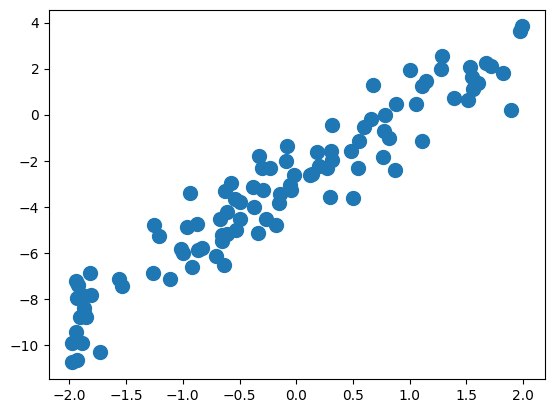

In [3]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [5]:
import torch.optim as optim
import torch.nn as nn


y_tensor = torch.tensor(y, dtype=torch.float32)


beta = nn.Parameter(torch.randn(1, requires_grad=True))
bias = nn.Parameter(torch.randn(1, requires_grad=True))


loss_fn = nn.MSELoss()


optimizer = optim.Adam([beta, bias], lr=0.01)


n_epochs = 1000


for epoch in range(n_epochs + 1):
    # Réinitialisation des gradients
    optimizer.zero_grad()


    predictions = (beta * xvec) + bias


    loss = loss_fn(predictions, y_tensor)


    loss.backward()


    optimizer.step()


    if epoch % 100 == 0:
        print(f'Epoch {epoch}: loss = {loss.item()}')

Epoch 0: loss = 23.973115921020508
Epoch 100: loss = 11.755908012390137
Epoch 200: loss = 5.374884128570557
Epoch 300: loss = 2.569180965423584
Epoch 400: loss = 1.5442941188812256
Epoch 500: loss = 1.233038067817688
Epoch 600: loss = 1.1526556015014648
Epoch 700: loss = 1.1343810558319092
Epoch 800: loss = 1.1306170225143433
Epoch 900: loss = 1.1299104690551758
Epoch 1000: loss = 1.1297916173934937


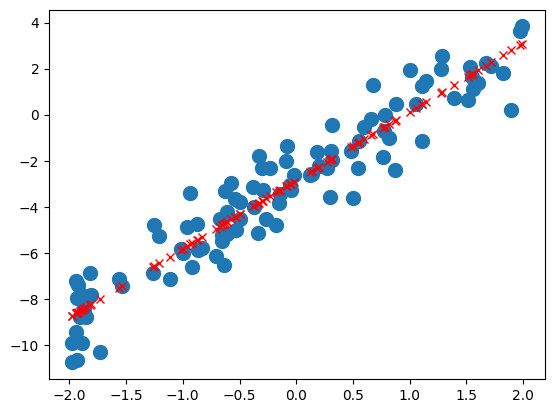

In [6]:
# Plot des predictions
#plt.plot(x, y, 'o', markersize=10)
#plt.plot(x, beta.detach().numpy() * x, 'rx')

y_tensor = torch.tensor(y, dtype=torch.float32)

plt.plot(xvec.numpy(), y_tensor.numpy(), 'o', markersize=10)
with torch.no_grad():  # Nous indiquons à PyTorch que nous ne calculons pas de gradients ici
    plt.plot(xvec.numpy(), (beta * xvec + bias).detach().numpy(), 'rx')

## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

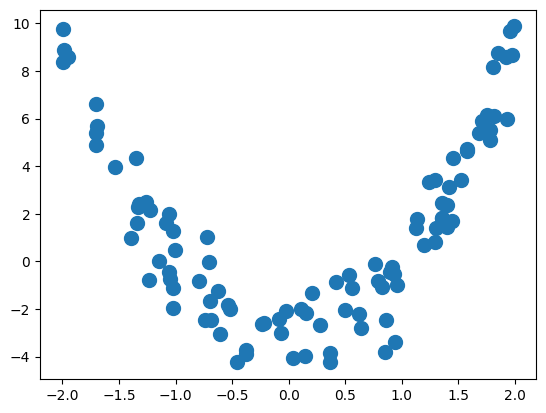

In [7]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP,self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size,hidden_size)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, 1)
            
        #self.layer = torch.nn.Linear(input_size, 1)

    def forward(self, X):
        X = self.layer1(X)
        X = self.relu(X)
        X = self.layer2(X)
        X = self.relu2(X)
        X = self.layer3(X)

        return X

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP 

In [9]:
input_size = 1
hidden_size = 64
n_epochs = 10000

y = torch.tensor(y, dtype=torch.float32).view(-1,1)
model = MLP(input_size,hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epochs in range(n_epochs+1):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if epochs % 1000 == 0:
        print(f'Epochs {epochs}: loss = {loss.item()}')

Epochs 0: loss = 16.513280868530273
Epochs 1000: loss = 1.0139786005020142
Epochs 2000: loss = 0.9944785833358765
Epochs 3000: loss = 0.9724398255348206
Epochs 4000: loss = 0.9472031593322754
Epochs 5000: loss = 0.9468977451324463
Epochs 6000: loss = 0.907134473323822
Epochs 7000: loss = 0.8897364735603333
Epochs 8000: loss = 0.8736987113952637
Epochs 9000: loss = 0.855603814125061
Epochs 10000: loss = 0.8797602653503418


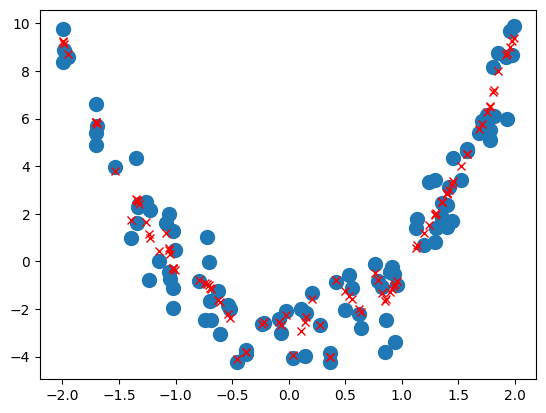

In [10]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
with torch.no_grad():
    plt.plot(x.numpy(), model(x).detach().numpy(), 'rx')

## Construire un Recurrent Neural Network (RNN) from scratch

### Données
 
Téléchargez [ici](https://download.pytorch.org/tutorial/data.zip) un jeu de données "nom" -> pays d'origine du nom.
Les noms de chaque pays sont dans leur fichier texte "[country].txt"

A partir de ces données, créez X la liste des noms et y le pays d'origine de chaque nom

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [11]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata
import os
import pandas as pd



def read_names(file):
    l=[]
    c = file.split('/')[-1]
    if os.path.exists(file):
        with open(file,'r', encoding='utf-8') as f:
            for line in f:
                txt = f.readline()
                l.append({'name': line, 'country': c})
            return l
    else :
        print('no such file directory')

data_list=[]
file_path= '../data/names'
fichier = [f for f in os.listdir(file_path)]
l=[]
for f in fichier:
    file = '/'.join([file_path,f])
    c = file.split('/')[-1]
    if os.path.exists(file):
        with open(file,'r', encoding='utf-8') as f:
                for line in f:
                    txt = f.readline()
                    l.append({'name': line, 'country': c})
    else :
        print('no such file directory')
print(l)

[{'name': 'Khoury\n', 'country': 'Arabic.txt'}, {'name': 'Daher\n', 'country': 'Arabic.txt'}, {'name': 'Nazari\n', 'country': 'Arabic.txt'}, {'name': 'Gerges\n', 'country': 'Arabic.txt'}, {'name': 'Guirguis\n', 'country': 'Arabic.txt'}, {'name': 'Sabbagh\n', 'country': 'Arabic.txt'}, {'name': 'Tahan\n', 'country': 'Arabic.txt'}, {'name': 'Aswad\n', 'country': 'Arabic.txt'}, {'name': 'Dagher\n', 'country': 'Arabic.txt'}, {'name': 'Isa\n', 'country': 'Arabic.txt'}, {'name': 'Nader\n', 'country': 'Arabic.txt'}, {'name': 'Abboud\n', 'country': 'Arabic.txt'}, {'name': 'Zogby\n', 'country': 'Arabic.txt'}, {'name': 'Bahar\n', 'country': 'Arabic.txt'}, {'name': 'Hanania\n', 'country': 'Arabic.txt'}, {'name': 'Tuma\n', 'country': 'Arabic.txt'}, {'name': 'Saliba\n', 'country': 'Arabic.txt'}, {'name': 'Handal\n', 'country': 'Arabic.txt'}, {'name': 'Amari\n', 'country': 'Arabic.txt'}, {'name': 'Atiyeh\n', 'country': 'Arabic.txt'}, {'name': 'Khouri\n', 'country': 'Arabic.txt'}, {'name': 'Baba\n', '

In [12]:
df = pd.DataFrame(l)
df['name'] = df['name'].replace('\n', '', regex=True)
df['country'] = df['country'].apply(lambda x :x.split('.')[0])
df.head()

,name,country
0,Khoury,Arabic
1,Daher,Arabic
2,Nazari,Arabic
3,Gerges,Arabic
4,Guirguis,Arabic


In [13]:
df.tail()

,name,country
10036,Tong,Vietnamese
10037,Trieu,Vietnamese
10038,Truong,Vietnamese
10039,Vinh,Vietnamese
10040,Vuu,Vietnamese


In [14]:
pat='../data/names'
path = Path(pat)
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue
            
        with open(file, encoding='utf-8') as f:
            names = [unicodeToAscii(line.strip()) for line in f]
        
        category = file.stem
        category_lines[category] = names

    return category_lines

# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [15]:
category_lines = read_names(path)
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [16]:
print(category_lines)

{'Arabic': ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', '

In [17]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [41]:
print(lineToTensor('my name is'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [19]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Andrysiak
category = Irish / line = Kennedy
category = French / line = Oliver
category = Spanish / line = Olmos
category = English / line = Capper
category = Chinese / line = Bei
category = Dutch / line = Spiker
category = German / line = Baumbach
category = Japanese / line = Baba
category = Italian / line = Pherigo


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)


In [20]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size= hidden_size
        self.hidden_state = nn.Parameter(torch.zeros(hidden_size))
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)




In [21]:
n_hidden = 128
rnn = SimpleRNN(n_letters, n_hidden, n_categories)
input = letterToTensor('A')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print(output.size())
print(next_hidden.size())



torch.Size([1, 18])
torch.Size([1, 128])


A l'aide de la negative log likelihood (torch.nn.NLLLoss), construisez une boucle optimisant ce modèle (optimizer, itération au sein des examples).

**Attention 1:** Ici, on n'a pas des tenseurs X, y. On va prendre les exemples 1 par 1.<br>
**Attention 2:** Si le modèle apprend les examples dans l'ordre (d'abord tous les noms arabes, puis tous les chinois, puis tous les tchèques, etc), cela changera grandement le résulat (et le modèle sera très mauvais)

5000 5.0 2.6888 Belo / Chinese WRONG (Portuguese)
10000 10.0 1.1739 Hiraoka / Japanese CORRECT
15000 15.0 1.7407 Gomes / Portuguese CORRECT
20000 20.0 1.8005 Han / Chinese WRONG (Korean)
25000 25.0 0.5565 Yim / Korean CORRECT
30000 30.0 0.0991 Miyazawa / Japanese CORRECT
35000 35.0 0.8680 Chung / Vietnamese CORRECT
40000 40.0 0.6266 Chweh / Korean CORRECT
45000 45.0 2.3390 Radcliffe / Czech WRONG (English)
50000 50.0 1.0988 Naifeh / Arabic CORRECT
55000 55.00000000000001 1.0051 Yeon / Chinese WRONG (Korean)
60000 60.0 1.1972 Dolezal / Czech CORRECT
65000 65.0 0.5447 Fung / Chinese CORRECT
70000 70.0 1.0328 Rodrigues / French WRONG (Portuguese)
75000 75.0 0.8012 Kaldin / Russian CORRECT
80000 80.0 3.9104 Tolkien / Russian WRONG (German)
85000 85.0 1.3412 Aldana / Italian WRONG (Spanish)
90000 90.0 3.6786 Padva / Czech WRONG (Russian)
95000 95.0 0.0400 Kaczka / Polish CORRECT
100000 100.0 0.4035 Kanaan / Arabic CORRECT


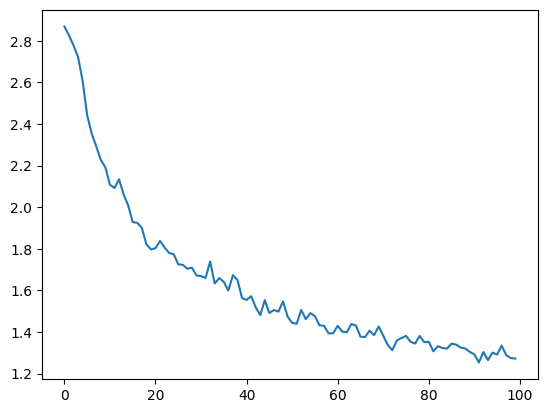

TypeError: 'Tensor' object is not callable

In [22]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

criterion = nn.NLLLoss()
lr = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr)

def train(line_tensor, category_tensor): #le nom_complet, country
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = lineToTensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    predict(sentence)

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

In [23]:
nb_data = len(df)
vocab_size = len(all_letters)
name_max_length = max(len(row['name']) for index, row in df.iterrows())

X = torch.zeros(nb_data, name_max_length, vocab_size)

for i, row in df.iterrows():
    name = row['name']
    category = row['country']
    for j, letter in enumerate(name):
        X[i][j][letterToIndex(letter)] = 1

In [24]:
print(X[0,1,:])
category_to_idx = {category: idx for idx, category in enumerate(all_categories)}
y = [category_to_idx[category] for category in df['country']]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

In [ ]:
import torch.nn.functional as F
class RNNmodel1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNmodel1, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden0 = torch.zeros(1,1, hidden_size)

    def forward(self, x):
        out, _ =self.rnn(x, self.hidden0)
        out = self.linear(out)
        output = F.log_softmax(out, dim=-1)
        return output


Entraînez le modèle avec des batchs de X, y

In [25]:
from torch.utils.data import TensorDataset, DataLoader

y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X, y_tensor)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train(batch):
    line_tensors, category_tensors = batch
    batch_loss = 0

    for i in range(line_tensors.size(0)):
        line_tensor = line_tensors[i]
        category_tensor = category_tensors[i].unsqueeze(0)
        hidden = rnn.init_hidden()

        for j in range(line_tensor.size(0)):
            output, hidden = rnn(line_tensor[j].unsqueeze(0), hidden)
            hidden = hidden.detach()  # Détacher l'état caché de l'arbre de calcul

        loss = criterion(output, category_tensor)
        batch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return output, batch_loss / line_tensors.size(0)

n_epochs = 5  # Nombre d'époques

for epoch in range(n_epochs+1):
    total_loss = 0
    for batch in data_loader:
        _, batch_loss = train(batch)
        total_loss += batch_loss

    print(f'Epoch {epoch} Loss {total_loss / len(data_loader)}')

Epoch 0 Loss 2.330777701595349
Epoch 1 Loss 2.1596521314054726
Epoch 2 Loss 2.0976600396547056
Epoch 3 Loss 2.073968753593703
Epoch 4 Loss 2.072403346947573
Epoch 5 Loss 2.0414866203705415


### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_dim, output_size):
        super(LSTMModel,self).__init__()
        self.hidden_size = hidden_size
        self.layer_dim = layer_dim #number of stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_size)
        c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_size)
        out, (hn, cn) = self.lstm(x,(h0,c0))
        out = self.fc(out[:, -1, :])
        return out


In [27]:

layer_dim = 2
batch_size_lstm = 32
data_loader_lstm = DataLoader(dataset, batch_size=batch_size_lstm, shuffle=True)

criterion_lstm = nn.NLLLoss()  # ou nn.MSELoss() selon votre tâche
optimizer_lstm = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model = LSTMModel(n_letters, n_hidden, layer_dim, n_categories)
def train(model, data_loader, criterion_lstm, optimizer_lstm, ):
    model.train()
    total_loss = 0

    for batch in data_loader:
        # Récupérer les données et les étiquettes du batch
        inputs, labels = batch
        inputs, labels = inputs, labels

        # Réinitialiser les gradients de l'optimiseur
        optimizer_lstm.zero_grad()

        # Exécuter la propagation avant
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion_lstm(outputs, labels)

        # Exécuter la rétropropagation
        loss.backward()

        # Mettre à jour les poids du modèle
        optimizer_lstm.step()

        # Accumuler la perte
        total_loss += loss.item()

    # Calculer la perte moyenne sur l'ensemble des données
    average_loss = total_loss / len(data_loader)
    return average_loss

n_epochs = 100  # Définir le nombre d'époques
for epoch in range(n_epochs+1):
    loss = train(model, data_loader_lstm, criterion_lstm, optimizer_lstm)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 0.024341765247659082
Epoch 10, Loss: 0.02434346677733965
Epoch 20, Loss: 0.02435227867088334
Epoch 30, Loss: 0.02433757759018202
Epoch 40, Loss: 0.02434312489260415
Epoch 50, Loss: 0.024340703092058706
Epoch 60, Loss: 0.02432770986713552
Epoch 70, Loss: 0.024344967777920876
Epoch 80, Loss: 0.024339495106618023
Epoch 90, Loss: 0.024341002479269746
Epoch 100, Loss: 0.02433866611385279


### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

In [28]:
def lineToIndexTensor(line):
    indices = [letterToIndex(letter) for letter in line]
    return torch.tensor(indices, dtype=torch.long)

# Préparation de X en utilisant les indices des lettres
X_indices = torch.zeros(nb_data, name_max_length, dtype=torch.long)

for i, row in df.iterrows():
    name = row['name']
    X_indices[i, :len(name)] = lineToIndexTensor(name)

In [29]:
print(X_indices[0])

tensor([36,  7, 14, 20, 17, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])


Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?

In [35]:
import torch.nn.functional as F
class RNNModel2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(RNNModel2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Applique l'embedding
        x = self.embedding(x)
        # Passage dans le RNN
        rnn_out, _ = self.rnn(x)
        # Application du softmax (ou log_softmax) à la sortie
        output = F.log_softmax(rnn_out, dim=-1)
        return output

In [31]:
dataset = TensorDataset(X_indices, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train():
    line_tensors, category_tensors = batch
    batch_loss = 0

    for i in range(line_tensors.size(0)):
        line_tensor = line_tensors[i]
        category_tensor = category_tensors[i]

        # Réinitialiser l'état caché pour chaque nouvelle ligne
        hidden = rnn.init_hidden()

        # Passez la séquence complète et l'état caché dans le RNN
        output, hidden = rnn(line_tensor, hidden)
        hidden = hidden.detach()  # Détacher l'état caché de l'arbre de calcul

        # Calcul de la perte
        loss = criterion(output, category_tensor)
        batch_loss += loss.item()

        # Optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return output, batch_loss / line_tensors.size(0)

n_epochs = 5  # Nombre d'époques

for epoch in range(n_epochs+1):
    total_loss = 0
    for batch in data_loader:
        _, batch_loss = train(batch)
        total_loss += batch_loss

    print(f'Epoch {epoch} Loss {total_loss / len(data_loader)}')

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [43]:
embedding_dim=32
rnnmodel = RNNModel2(n_letters, embedding_dim,  n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
dataset = TensorDataset(X_indices, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Entraînement

def train(model, data_loader, criterion, optimizer):
    model.train()  # Met le modèle en mode entraînement
    total_loss = 0

    for batch in data_loader:
        inputs, labels = batch
        inputs, labels = inputs, labels

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Passer les données à travers le modèle
        output = model(inputs)

        # La sortie du RNN sera (batch_size, seq_len, output_size), mais
        # pour la perte, nous avons besoin de (batch_size, output_size).
        # Utilisez output[:, -1, :] pour obtenir la dernière sortie de chaque séquence.
        output = output[:, -1, :]

        # Calculer la perte
        loss = criterion(output, labels)
        total_loss += loss.item()

        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

    # Retourne la perte moyenne pour le batch
    return total_loss / len(data_loader)

n_epochs = 5
for epoch in range(n_epochs):
    epoch_loss = train(rnnmodel, data_loader, criterion, optimizer)
    print(f'Epoch {epoch}, Loss: {epoch_loss}')

IndexError: index out of range in self

In [33]:
print(n_letters)

57
